In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np

# Paths to your datasets and labels
train_dataset_dir = r"D:\Data_sets\DAiSEE\DAiSEE\DataSet\Annote1_Train"
val_dataset_dir = r"D:\Data_sets\DAiSEE\DAiSEE\DataSet\Annote1_Val"
test_dataset_dir = r"D:\Data_sets\DAiSEE\DAiSEE\DataSet\Annote1_Test"

train_labels_file = r"D:\Data_sets\DAiSEE\DAiSEE\Labels\TrainLabels.csv"
val_labels_file = r"D:\Data_sets\DAiSEE\DAiSEE\Labels\ValidationLabels.csv"
test_labels_file = r"D:\Data_sets\DAiSEE\DAiSEE\Labels\TestLabels.csv"

# Function to load dataset and labels
def load_data(dataset_dir, labels_file):
    labels_df = pd.read_csv(labels_file)
    filenames = labels_df['ClipID'].values
    labels = labels_df[['Boredom', 'Engagement', 'Confusion', 'Frustration']].values
    
    data = []
    for filename in filenames:
        # Remove extensions if they exist
        base_filename = os.path.splitext(filename)[0]
        
        # Construct the image path
        img_path = os.path.join(dataset_dir, f"{base_filename}.png")
        
        # Debugging: print the path
        print(f"Checking image path: {img_path}")
        
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=(224, 224))  # Adjust target_size as needed
            img_array = img_to_array(img)
            data.append(img_array)
        else:
            print(f"Image {img_path} not found.")
    
    data = np.array(data)
    
    return data, labels

# Load training data
train_data, train_labels = load_data(train_dataset_dir, train_labels_file)

# Load validation data
val_data, val_labels = load_data(val_dataset_dir, val_labels_file)

# Load test data
test_data, test_labels = load_data(test_dataset_dir, test_labels_file)

# Check shapes to ensure everything loaded correctly
print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation data shape: {val_data.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_labels.shape}")

Checking image path: D:\Data_sets\DAiSEE\DAiSEE\DataSet\Annote1_Train\1100011002.png
Checking image path: D:\Data_sets\DAiSEE\DAiSEE\DataSet\Annote1_Train\1100011003.png
Checking image path: D:\Data_sets\DAiSEE\DAiSEE\DataSet\Annote1_Train\1100011004.png
Checking image path: D:\Data_sets\DAiSEE\DAiSEE\DataSet\Annote1_Train\1100011005.png
Checking image path: D:\Data_sets\DAiSEE\DAiSEE\DataSet\Annote1_Train\1100011006.png
Checking image path: D:\Data_sets\DAiSEE\DAiSEE\DataSet\Annote1_Train\1100011007.png
Checking image path: D:\Data_sets\DAiSEE\DAiSEE\DataSet\Annote1_Train\1100011008.png
Checking image path: D:\Data_sets\DAiSEE\DAiSEE\DataSet\Annote1_Train\1100011009.png
Checking image path: D:\Data_sets\DAiSEE\DAiSEE\DataSet\Annote1_Train\1100011010.png
Checking image path: D:\Data_sets\DAiSEE\DAiSEE\DataSet\Annote1_Train\1100011011.png
Checking image path: D:\Data_sets\DAiSEE\DAiSEE\DataSet\Annote1_Train\1100011012.png
Checking image path: D:\Data_sets\DAiSEE\DAiSEE\DataSet\Annote1_T

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Input shape for your images
input_shape = (224, 224, 3)  # Adjust according to your image dimensions and channels

# Define the ResNet50 backbone
def create_resnet50_backbone(input_shape):
    # Load ResNet50 model pretrained on ImageNet without top (fully connected layers)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Add additional layers for feature extraction
    inputs = Input(shape=input_shape, name='input_image')
    x = base_model(inputs)
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    backbone = Model(inputs, x, name='ResNet50_backbone')
    
    return backbone

# Create ResNet50 backbone
resnet50_backbone = create_resnet50_backbone(input_shape)

# Print summary to see the architecture
resnet50_backbone.summary()

Model: "ResNet50_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 256)      │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 7, 7, 256)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,307,584 (107.98 MB)

 Trainable params: 28,253,952 (107.78 MB)

 Non-trainable params: 53,632 (209.50 KB)

In [4]:
import numpy as np

# Define anchor box scales and aspect ratios
anchor_sizes = [32, 64, 128, 256, 512]  # Sizes of the anchor boxes in pixels
aspect_ratios = [0.5, 1.0, 2.0]  # Aspect ratios of the anchor boxes (width/height)

# Function to generate anchor boxes
def generate_anchor_boxes(base_size, aspect_ratios):
    anchor_boxes = []
    
    for ratio in aspect_ratios:
        width = base_size * np.sqrt(ratio)
        height = base_size / np.sqrt(ratio)
        
        # Create anchor box centered at (0, 0)
        anchor_boxes.append([-width / 2.0, -height / 2.0, width / 2.0, height / 2.0])
    
    return np.array(anchor_boxes)

# Function to generate anchor boxes at different scales and aspect ratios
def generate_all_anchor_boxes(scales, aspect_ratios):
    anchor_boxes = []
    
    for scale in scales:
        anchor_boxes_scale = []
        for size in scale:
            anchor_boxes_scale.extend(generate_anchor_boxes(size, aspect_ratios))
        anchor_boxes.append(anchor_boxes_scale)
    
    return np.array(anchor_boxes)

# Generate anchor boxes
anchor_boxes = generate_all_anchor_boxes([anchor_sizes], aspect_ratios)

# Print anchor boxes
print("Generated Anchor Boxes:")
for i, anchors in enumerate(anchor_boxes):
    print(f"Scale {i}:")
    for j, anchor in enumerate(anchors):
        print(f"Anchor {j}: {anchor}")

Generated Anchor Boxes:
Scale 0:
Anchor 0: [-11.3137085 -22.627417   11.3137085  22.627417 ]
Anchor 1: [-16. -16.  16.  16.]
Anchor 2: [-22.627417  -11.3137085  22.627417   11.3137085]
Anchor 3: [-22.627417 -45.254834  22.627417  45.254834]
Anchor 4: [-32. -32.  32.  32.]
Anchor 5: [-45.254834 -22.627417  45.254834  22.627417]
Anchor 6: [-45.254834   -90.50966799  45.254834    90.50966799]
Anchor 7: [-64. -64.  64.  64.]
Anchor 8: [-90.50966799 -45.254834    90.50966799  45.254834  ]
Anchor 9: [ -90.50966799 -181.01933598   90.50966799  181.01933598]
Anchor 10: [-128. -128.  128.  128.]
Anchor 11: [-181.01933598  -90.50966799  181.01933598   90.50966799]
Anchor 12: [-181.01933598 -362.03867197  181.01933598  362.03867197]
Anchor 13: [-256. -256.  256.  256.]
Anchor 14: [-362.03867197 -181.01933598  362.03867197  181.01933598]


In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Add, Input, UpSampling2D
import tensorflow.keras.backend as K

# Example usage: Obtain ResNet50 backbone outputs
input_shape = (224, 224, 3)  # Example input shape
inputs = Input(shape=input_shape)
resnet50 = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

# Accessing ResNet50 backbone outputs
C3_output = resnet50.get_layer('conv3_block4_out').output  # Output from ResNet50 block 3
C4_output = resnet50.get_layer('conv4_block6_out').output  # Output from ResNet50 block 4
C5_output = resnet50.get_layer('conv5_block3_out').output  # Output from ResNet50 block 5

# Function to build FPN
def build_feature_pyramid(backbone_output):
    # Feature Pyramid Network implementation
    C3, C4, C5 = backbone_output
    
    # P5 stage (smallest feature map)
    P5 = Conv2D(256, (1, 1), strides=(1, 1), padding='same', name='P5')(C5)
    
    # P4 stage
    P4 = Add(name='P4_Add')([
        Conv2D(256, (1, 1), strides=(1, 1), padding='same', name='C4_reduced')(C4),
        UpSampling2D(size=(2, 2))(P5)
    ])
    P4 = Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='P4')(P4)
    
    # P3 stage
    P3 = Add(name='P3_Add')([
        Conv2D(256, (1, 1), strides=(1, 1), padding='same', name='C3_reduced')(C3),
        UpSampling2D(size=(2, 2))(P4)
    ])
    P3 = Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='P3')(P3)
    
    # P6 stage (largest feature map)
    P6 = Conv2D(256, (3, 3), strides=(2, 2), padding='same', name='P6')(C5)
    
    # P7 stage (optional, extra large feature map)
    P7 = Conv2D(256, (3, 3), strides=(2, 2), padding='same', name='P7')(Activation('relu')(P6))
    
    return [P3, P4, P5, P6, P7]

# Example usage: Build feature pyramid on ResNet50 outputs
backbone_output = [C3_output, C4_output, C5_output]
feature_pyramid = build_feature_pyramid(backbone_output)

# Print summary to see the architecture
for level, fpn_output in enumerate(feature_pyramid):
    print(f"Feature Pyramid Level {level + 3} (P{level + 3}):")
    print(fpn_output.shape)

Feature Pyramid Level 3 (P3):
(None, 28, 28, 256)
Feature Pyramid Level 4 (P4):
(None, 14, 14, 256)
Feature Pyramid Level 5 (P5):
(None, 7, 7, 256)
Feature Pyramid Level 6 (P6):
(None, 4, 4, 256)
Feature Pyramid Level 7 (P7):
(None, 2, 2, 256)


In [6]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Concatenate, Input
from tensorflow.keras.models import Model

# Function to build RetinaNet head
def build_retinanet_head(num_classes, num_feature_maps, feature_pyramid):
    # Initialize lists to store classification and regression subnetworks
    classification_subnets = []
    regression_subnets = []
    
    # Define number of anchors per feature map level
    num_anchors = 9  # Adjust based on the number of anchor boxes per feature map level
    
    # Loop through each feature map level
    for i in range(num_feature_maps):
        # Classification subnet
        cls_subnet = Conv2D(num_anchors * num_classes, (3, 3), padding='same', name=f'cls_subnet_P{i+3}')(feature_pyramid[i])
        cls_subnet = Flatten(name=f'cls_flatten_P{i+3}')(cls_subnet)
        classification_subnets.append(cls_subnet)
        
        # Regression subnet
        reg_subnet = Conv2D(num_anchors * 4, (3, 3), padding='same', name=f'reg_subnet_P{i+3}')(feature_pyramid[i])
        reg_subnet = Flatten(name=f'reg_flatten_P{i+3}')(reg_subnet)
        regression_subnets.append(reg_subnet)
    
    # Concatenate all subnet outputs
    cls_outputs = Concatenate(axis=1, name='concat_cls')(classification_subnets)
    reg_outputs = Concatenate(axis=1, name='concat_reg')(regression_subnets)
    
    # Classification output
    cls_outputs = Dense(num_anchors * num_classes, activation='sigmoid', name='cls_output')(cls_outputs)
    
    # Regression output
    reg_outputs = Dense(num_anchors * 4, name='reg_output')(reg_outputs)
    
    return cls_outputs, reg_outputs

# Example usage: Build RetinaNet head
num_classes = 4  # Number of classes (Boredom, Engagement, Confusion, Frustration)
num_feature_maps = len(feature_pyramid)  # Number of feature maps (P3 to P7)

# Assuming `feature_pyramid` is defined and contains feature maps P3 to P7
# Constructing the RetinaNet head
cls_outputs, reg_outputs = build_retinanet_head(num_classes, num_feature_maps, feature_pyramid)

# Print summaries to see the architecture
print("Classification Output Shape:", cls_outputs.shape)
print("Regression Output Shape:", reg_outputs.shape)

Classification Output Shape: (None, 36)
Regression Output Shape: (None, 36)


In [7]:
import tensorflow as tf

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
        
        # Clip predictions to avoid log(0) error
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        
        # Compute cross entropy loss
        ce_loss = -y_true * tf.math.log(y_pred)
        
        # Compute the focal loss components
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1 - y_pred, gamma)
        
        # Compute the focal loss
        focal_loss = alpha_factor * modulating_factor * ce_loss
        return tf.reduce_sum(focal_loss, axis=1)  # Sum over classes
    
    return focal_loss_fixed



# Smooth L1 Loss for regression
def smooth_l1_loss(sigma=3.0):
    def smooth_l1_loss_fixed(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        less_than_one = tf.cast(tf.less(diff, 1.0 / sigma), tf.float32)
        loss = less_than_one * 0.5 * sigma * tf.square(diff) + (1 - less_than_one) * (diff - 0.5 / sigma)
        return tf.reduce_sum(loss, axis=-1)
    
    return smooth_l1_loss_fixed

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a simple RetinaNet-like model for illustration
def create_model(input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape, name='input_layer_8')
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    cls_output = layers.Dense(4, activation='sigmoid', name='cls_output')(x)
    reg_output = layers.Dense(4, activation='linear', name='reg_output')(x)
    model = models.Model(inputs=inputs, outputs=[cls_output, reg_output])
    return model

# Create and compile the model
retinanet_model = create_model()
retinanet_model.compile(optimizer='adam', loss={'cls_output': 'binary_crossentropy', 'reg_output': 'mse'})

# Print the model summary
print(retinanet_model.summary())

# Define the batch size
batch_size = 8

# Check the shapes and types of the data
print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation data shape: {val_data.shape}, Validation labels shape: {val_labels.shape}")

# Adjust train_data and train_labels to ensure they match in shape
min_samples = min(train_data.shape[0], train_labels.shape[0])
train_data = train_data[:min_samples]
train_labels = train_labels[:min_samples]

# Log adjusted shapes
print(f"Adjusted Train data shape: {train_data.shape}, Adjusted Train labels shape: {train_labels.shape}")

# Create a generator function
def data_generator(data, labels, batch_size):
    data_size = data.shape[0]
    while True:
        for start in range(0, data_size, batch_size):
            end = min(start + batch_size, data_size)
            yield {'input_layer_8': data[start:end]}, {'cls_output': labels[start:end], 'reg_output': labels[start:end]}

# Create tf.data.Dataset from the generator
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_data, train_labels, batch_size),
    output_types=({'input_layer_8': tf.float32}, {'cls_output': tf.float32, 'reg_output': tf.float32}),
    output_shapes=({'input_layer_8': (None, 224, 224, 3)}, {'cls_output': (None, 4), 'reg_output': (None, 4)})
).repeat()

min_val_samples = min(val_data.shape[0], val_labels.shape[0])
val_data = val_data[:min_val_samples]
val_labels = val_labels[:min_val_samples]

# Log adjusted shapes
print(f"Adjusted Validation data shape: {val_data.shape}, Adjusted Validation labels shape: {val_labels.shape}")

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_data, val_labels, batch_size),
    output_types=({'input_layer_8': tf.float32}, {'cls_output': tf.float32, 'reg_output': tf.float32}),
    output_shapes=({'input_layer_8': (None, 224, 224, 3)}, {'cls_output': (None, 4), 'reg_output': (None, 4)})
).repeat()

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('retinanet_best.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

# Increase the number of epochs
epochs = 50

# Train the model
try:
    retinanet_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks,
        steps_per_epoch=len(train_data) // batch_size,
        validation_steps=len(val_data) // batch_size
    )
except Exception as e:
    print(f"An error occurred during training: {e}")

# Save the model
try:
    retinanet_model.save('retinanet_final.keras')
except Exception as e:
    print(f"An error occurred during model saving: {e}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 222, 222,  │        896 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 54,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 186624)    │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 23,888,000 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_output (Dense)  │ (None, 4)         │        516 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reg_output (Dense)  │ (None, 4)         │        516 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,908,424 (91.20 MB)

 Trainable params: 23,908,424 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

None
Train data shape: (5358, 224, 224, 3), Train labels shape: (5358, 4)
Validation data shape: (1429, 224, 224, 3), Validation labels shape: (1429, 4)
Adjusted Train data shape: (5358, 224, 224, 3), Adjusted Train labels shape: (5358, 4)
Adjusted Validation data shape: (1429, 224, 224, 3), Adjusted Validation labels shape: (1429, 4)
Epoch 1/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 402s 597ms/step - loss: 92452.3828 - val_loss: -52632.2344 - learning_rate: 0.0010
Epoch 2/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 396s 592ms/step - loss: -55957.4531 - val_loss: 188635.5312 - learning_rate: 0.0010
Epoch 3/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 380s 569ms/step - loss: -288109.0938 - val_loss: -509199.0312 - learning_rate: 0.0010
Epoch 4/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 380s 567ms/step - loss: -1010254.2500 - val_loss: 1139449.6250 - learning_rate: 0.0010
Epoch 5/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 378s 565ms/step - loss: -2987191.2500 - val_loss: 17636358.0000 - learning_rate: 0.0010
Epoch 6/50
669/669 ━━━━━━━━━━━━━━━━

In [9]:
# Load the best weights into the model
try:
    retinanet_model.load_weights('retinanet_best.keras')
    print("Weights loaded successfully.")
except Exception as e:
    print(f"An error occurred while loading weights: {e}")

Weights loaded successfully.


In [10]:
# Evaluate the model on the validation data
validation_loss = retinanet_model.evaluate(val_dataset, steps=len(val_data) // batch_size)
print(f"Validation loss: {validation_loss}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: -584165440.0000
Validation loss: -603042048.0


Loaded image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Image: 928901013.png
Prediction boxes: [[0.0000000e+00 1.0000000e+00 0.0000000e+00 3.6647704e-18]]
Prediction scores: [88.817726]
Prediction classes: [3]


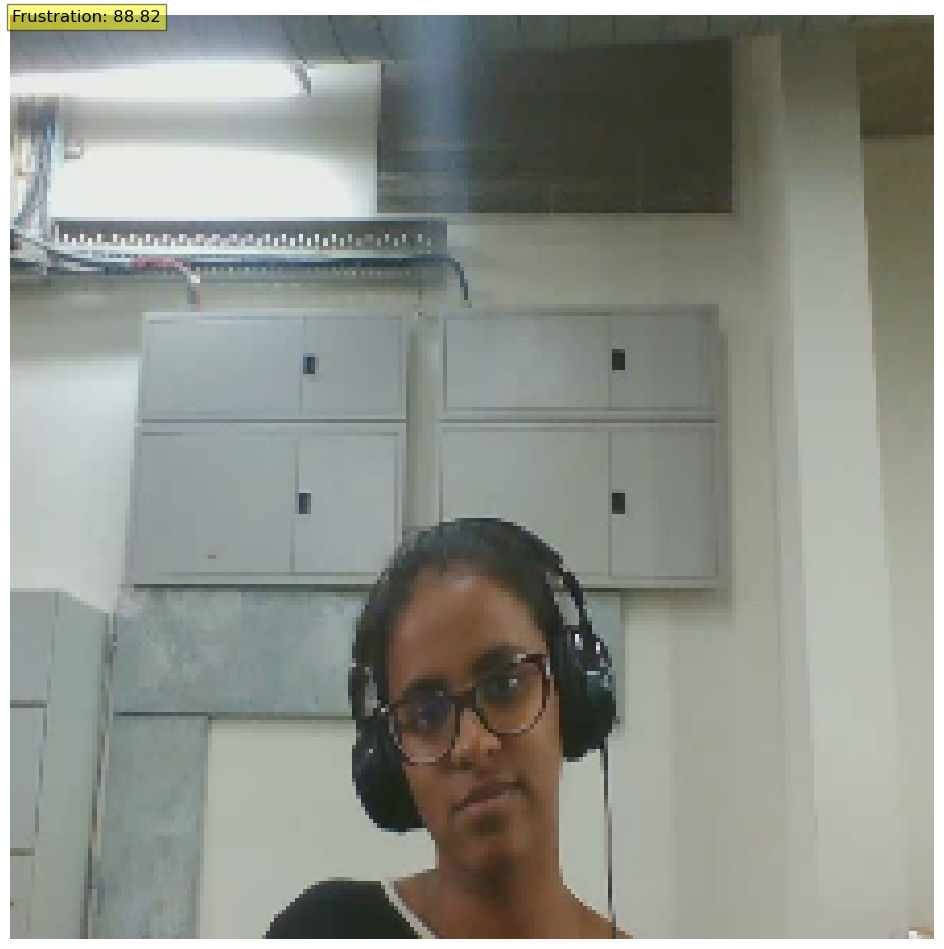

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load and preprocess image
def load_image(image_path, img_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0  # Normalize image to [0, 1]
        return img
    else:
        raise FileNotFoundError(f"Image not found at path: {image_path}")

# Post-process model predictions
def postprocess_predictions(predictions, img_shape, score_threshold=0.5):
    boxes, class_probs = predictions
    boxes = np.squeeze(boxes)  # Remove batch dimension
    class_probs = np.squeeze(class_probs)
    
    # Filter out low confidence boxes
    scores = np.max(class_probs, axis=-1)
    classes = np.argmax(class_probs, axis=-1)
    
    keep = scores >= score_threshold
    boxes = boxes[keep]
    scores = scores[keep]
    classes = classes[keep]

    return boxes, scores, classes

# Display the image with bounding boxes
def show_image_with_prediction(image, boxes, scores, classes, categories, figsize=(12, 12)):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    plt.figure(figsize=figsize)
    plt.imshow(image)
    
    for box, score, _class in zip(boxes, scores, classes):
        x1, y1, x2, y2 = box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', fill=False, linewidth=2))
        plt.text(x1, y1, f'{categories[_class]}: {score:.2f}', bbox={'facecolor': 'yellow', 'alpha': 0.5}, fontsize=12, color='black')
    
    plt.axis('off')
    plt.show()

# Corrected path to the new image
new_image_path = "D:\Data_sets\DAiSEE\DAiSEE\DataSet\Test1_Frames\928901\928901013\928901013.png"

# Load the new image
try:
    new_data = load_image(new_image_path)
    new_data = np.expand_dims(new_data, axis=0)  # Add batch dimension
    print(f"Loaded image shape: {new_data.shape}")
except Exception as e:
    print(f"Error loading image: {e}")

# Define categories
categories = ['Boredom', 'Engagement', 'Confusion', 'Frustration']

# Ensure the model is loaded
try:
    retinanet_model = tf.keras.models.load_model('retinanet_final.keras', compile=False)
except Exception as e:
    print(f"Error loading model: {e}")

if 'retinanet_model' in locals():
    if new_data.shape[0] > 0:
        # Make predictions on the new image
        predictions = retinanet_model.predict(new_data)

        # Post-process predictions
        boxes, scores, classes = postprocess_predictions(predictions, new_data.shape[1:])

        # Show the image with its prediction
        print(f"Image: {os.path.basename(new_image_path)}")
        print(f"Prediction boxes: {boxes}")
        print(f"Prediction scores: {scores}")
        print(f"Prediction classes: {classes}")
        show_image_with_prediction(new_data[0], boxes, scores, classes, categories)
    else:
        print("No data loaded. Please check the input path and data format.")
else:
    print("Model is not loaded. Please load the model before making predictions.")


Error loading image: Image not found at path: D:\Data_sets\DAiSEE\DAiSEE\DataSet\Test1_Framesň042ň0421007ň0421007.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Image: Test1_Framesň042ň0421007ň0421007.png
Prediction boxes: [[0.0000000e+00 1.0000000e+00 0.0000000e+00 3.6647704e-18]]
Prediction scores: [88.817726]
Prediction classes: [3]


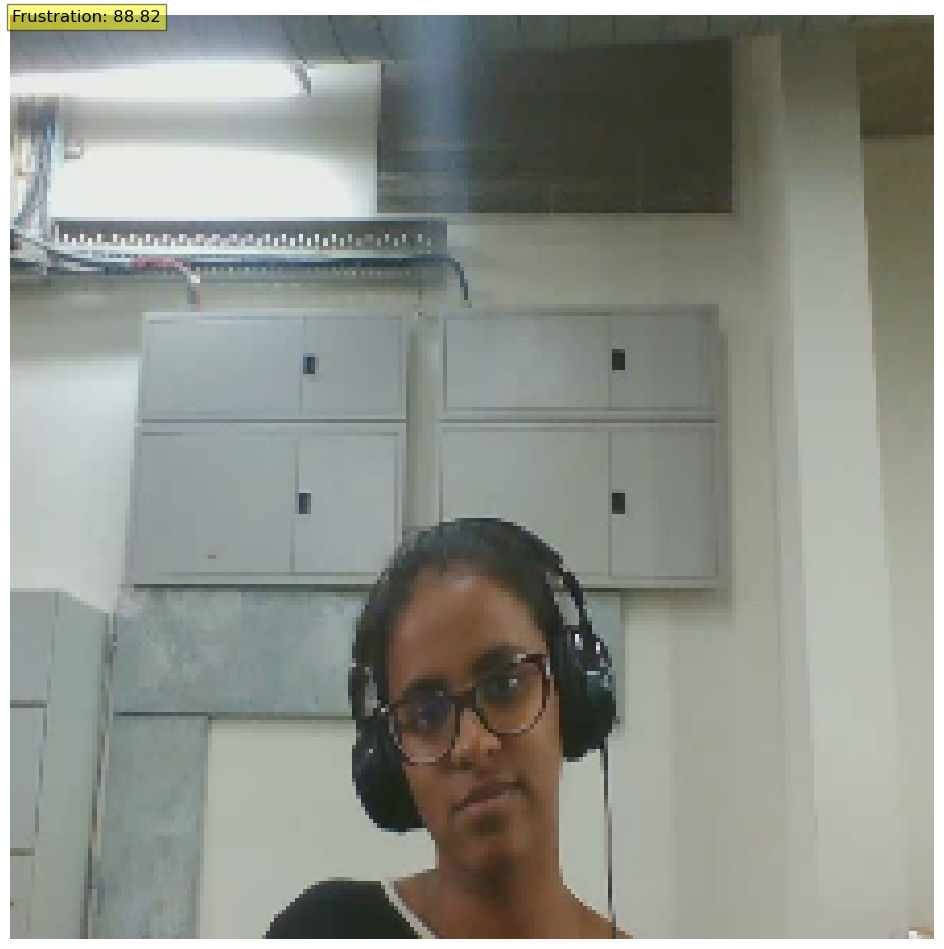

Output image saved at: D:\Data_sets\DAiSEE\DAiSEE\DataSet\Output\predicted_Test1_Framesň042ň0421007ň0421007.png


In [3]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load and preprocess image
def load_image(image_path, img_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0  # Normalize image to [0, 1]
        return img
    else:
        raise FileNotFoundError(f"Image not found at path: {image_path}")

# Post-process model predictions
def postprocess_predictions(predictions, img_shape, score_threshold=0.5):
    boxes, class_probs = predictions
    boxes = np.squeeze(boxes)  # Remove batch dimension
    class_probs = np.squeeze(class_probs)
    
    # Filter out low confidence boxes
    scores = np.max(class_probs, axis=-1)
    classes = np.argmax(class_probs, axis=-1)
    
    keep = scores >= score_threshold
    boxes = boxes[keep]
    scores = scores[keep]
    classes = classes[keep]

    return boxes, scores, classes

# Display the image with bounding boxes and save the result
def show_and_save_image_with_prediction(image, boxes, scores, classes, categories, output_path, figsize=(12, 12)):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    plt.figure(figsize=figsize)
    plt.imshow(image)
    
    for box, score, _class in zip(boxes, scores, classes):
        x1, y1, x2, y2 = box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', fill=False, linewidth=2))
        plt.text(x1, y1, f'{categories[_class]}: {score:.2f}', bbox={'facecolor': 'yellow', 'alpha': 0.5}, fontsize=12, color='black')
    
    plt.axis('off')

    # Save the image
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    
    # Display the image in the notebook
    plt.show()

# Corrected path to the new image
new_image_path = "D:\Data_sets\DAiSEE\DAiSEE\DataSet\Test1_Frames\510042\5100421007\5100421007.png"

# Load the new image
try:
    new_data = load_image(new_image_path)
    new_data = np.expand_dims(new_data, axis=0)  # Add batch dimension
    print(f"Loaded image shape: {new_data.shape}")
except Exception as e:
    print(f"Error loading image: {e}")

# Define categories
categories = ['Boredom', 'Engagement', 'Confusion', 'Frustration']

# Ensure the model is loaded
try:
    retinanet_model = tf.keras.models.load_model('retinanet_final.keras', compile=False)
except Exception as e:
    print(f"Error loading model: {e}")

if 'retinanet_model' in locals():
    if new_data.shape[0] > 0:
        # Make predictions on the new image
        predictions = retinanet_model.predict(new_data)

        # Post-process predictions
        boxes, scores, classes = postprocess_predictions(predictions, new_data.shape[1:])

        # Create the output path with "predicted_" prefix
        base_name = os.path.basename(new_image_path)
        output_name = f"predicted_{base_name}"
        output_path = os.path.join("D:\Data_sets\DAiSEE\DAiSEE\DataSet\Output", output_name)
        
        # Show and save the image with its prediction
        print(f"Image: {base_name}")
        print(f"Prediction boxes: {boxes}")
        print(f"Prediction scores: {scores}")
        print(f"Prediction classes: {classes}")
        show_and_save_image_with_prediction(new_data[0], boxes, scores, classes, categories, output_path)
        print(f"Output image saved at: {output_path}")
    else:
        print("No data loaded. Please check the input path and data format.")
else:
    print("Model is not loaded. Please load the model before making predictions.")
